In [324]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# A. データ探索
* * *

In [325]:
# Load in the train and test datasets
df_train = pd.read_csv('../testdata/train.csv')
df_test = pd.read_csv('../testdata/test.csv')
combine = [df_train, df_test]

# Store our passenger ID for easy access
PassengerId = df_test['PassengerId']

In [326]:
df_train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [327]:
df_test.count()

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64

In [328]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [329]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [330]:
df_train.isnull().any()
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

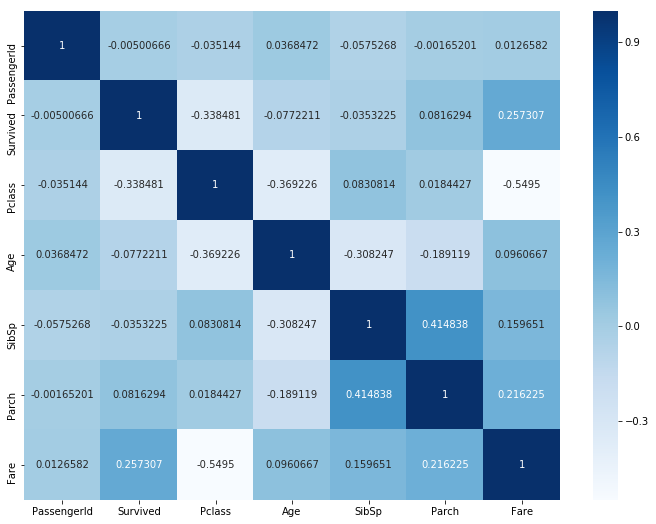

In [331]:
plt.figure(figsize=(12, 9))
sns.heatmap(df_train.corr(), annot=True, fmt='g', cmap='Blues')

#### データ探索・まとめ
1. ダミー変数化: Sex, Ticket, Embarked
2. 欠損値補完: Age, Cabin, Embarked
3. 検討要： 
    - Nameの使い道、かつダミー変数化
    - cabinがPclassと相関があるか？偏相関も見て確認。cabinは欠測値が多いため削除したい
    - EmbarkedとAgeはどうやって補完するか。knnは良いと別サイトに書いてあった。>>> knnとimputerでやるときと差が出るか確認したい。
4. モデル：　Emsamblingでひとまず試すことを目標。時間が合ったら単純にRF, logistic regressionと比較してみたい。

# B. 前処理
* * * *

In [332]:
df_train = df_train.drop('PassengerId', axis=1)
df_test = df_test.drop('PassengerId', axis=1)

## 1. ダミー変数化: Sex, Ticket, Embarked

Dummy Sex feature.

In [333]:
df_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [334]:
df_train['Sex'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_test['Sex'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

I want to dummy Ticket feature however since too various values are set, Ticket is out of features.

In [335]:
df_train.Ticket.value_counts().count()

681

In [336]:
# Feature selection
drop_elements = ['Ticket']
df_train = df_train.drop(drop_elements, axis = 1)
df_test = df_test.drop(drop_elements, axis = 1)

I was going to dummy Embarked feature however there is NaN in two records. This will be dummied later.

In [337]:
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [338]:
embarked_train_dummy = pd.get_dummies(df_train['Embarked'])
df_train = pd.concat((df_train, embarked_train_dummy),axis=1)

df_train = df_train.drop('Embarked',axis=1)
df_train = df_train.drop('S',axis=1) # C=0 & Q=0 > S

embarked_test_dummy = pd.get_dummies(df_test['Embarked'])
df_test = pd.concat((df_test, embarked_test_dummy),axis=1)

df_test = df_test.drop('Embarked',axis=1)
df_test = df_test.drop('S',axis=1) # C=0 & Q=0 > S

## 3. 特徴量整形

### Cabin
先頭一文字のみ抽出・変更。

In [339]:
df_train['Cabin'] = df_train["Cabin"].apply(lambda x: "U" if type(x) == float else x[0])

In [340]:
df_train['Cabin'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

In [341]:
pd.crosstab(df_train['Cabin'], df_train['Pclass'])

Pclass,1,2,3
Cabin,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0
U,40,168,479


In [342]:
#g = sns.factorplot(x="Cabin", col="Pclass",
#                   data=df_train, kind="count",
#                   size=4, aspect=.7);

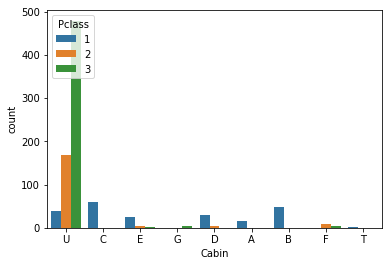

In [343]:
ax = sns.countplot(x="Cabin", hue="Pclass", data=df_train)

In [344]:
#g = sns.FacetGrid(df_train, col='Pclass')
#g.map(sns.countplot, 'Cabin')

In [345]:
cabin_dummy = pd.get_dummies(df_train['Cabin'], prefix='Cabin')
df_train = pd.concat((df_train, cabin_dummy),axis=1)

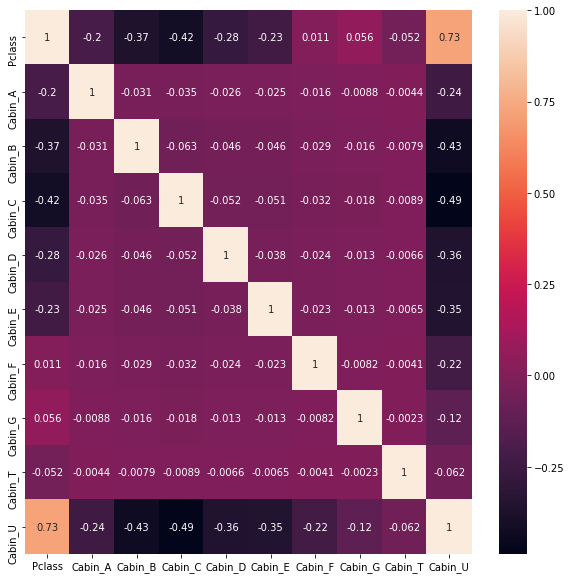

In [346]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train[['Pclass','Cabin_A','Cabin_B','Cabin_C','Cabin_D','Cabin_E','Cabin_F','Cabin_G','Cabin_T','Cabin_U']].corr(), annot=True)

相関係数はそこまで高くないが、PclassとCabinには多少の相関があるようには見える。Pclass=3だと、Cabin=E,F,G,Tといった下位の船室と予測できる。
よって特徴量としてはPclassを使い、Cabinは削除することとする。

In [347]:
drop_elements = ['Cabin', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U']
df_train = df_train.drop(drop_elements, axis = 1)
df_test = df_test.drop('Cabin', axis = 1)

## 3. 特徴量作成

### Title
Name featureから敬称を抽出する。

In [348]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

df_train['Title'] = df_train['Name'].apply(get_title)
df_test['Title'] = df_test['Name'].apply(get_title)
#dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [349]:
pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [350]:
df_train['Title'] = df_train['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                               'Jonkheer', 'Dona'], 'Rare')

df_train['Title'] = df_train['Title'].replace('Mlle', 'Miss')
df_train['Title'] = df_train['Title'].replace('Ms', 'Miss')
df_train['Title'] = df_train['Title'].replace('Mme', 'Mrs')

In [351]:
df_test['Title'] = df_test['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
                                               'Don', 'Dr', 'Major', 'Rev', 'Sir',\
                                               'Jonkheer', 'Dona'], 'Rare')

df_test['Title'] = df_test['Title'].replace('Mlle', 'Miss')
df_test['Title'] = df_test['Title'].replace('Ms', 'Miss')
df_test['Title'] = df_test['Title'].replace('Mme', 'Mrs')

In [352]:
pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,0,1
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


In [353]:
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)

In [354]:
title_dummy = pd.get_dummies(df_train['Title'])
df_train = pd.concat((df_train,title_dummy),axis=1)
df_train = df_train.drop(['Title', 'Rare'],axis=1) # When all titles are 0, it means "Rare"

title_dummy = pd.get_dummies(df_test['Title'])
df_test = pd.concat((df_test,title_dummy),axis=1)
df_test = df_test.drop(['Title', 'Rare'],axis=1) # When all titles are 0, it means "Rare"

### Familiysize
SibSP + Parch + 1 で自分を含めて何人の家族で乗船しているかを示すfeatureを作成。

In [355]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

### IsAlone
自分一人のみ乗船している（Familysizeが1）かを示すfeatureを作成。

In [356]:
df_train['IsAlone'] = 0
df_train.loc[df_train['FamilySize'] == 1, 'IsAlone'] = 1

df_test['IsAlone'] = 0
df_test.loc[df_test['FamilySize'] == 1, 'IsAlone'] = 1

In [357]:
len(df_train.columns)

15

In [358]:
len(df_test.columns)

14

## 2. 欠損値補完: Age, Embarked
knnとRFで欠損値を埋めたdfをそれぞれ作成する。

### Fare

In [359]:
df_test['Fare'] = df_test['Fare'].fillna(df_train['Fare'].median())

### knn

訓練データ（df_train + df_test）を作成

In [360]:
X_train = df_train[df_train['Age'].notnull()].iloc[:,:]
X_test = df_test[df_test['Age'].notnull()].iloc[:,:]
X_train = pd.concat((X_train,X_test), ignore_index=True)
X_train = X_train.drop('Age',axis=1)
X_train = X_train.drop('Survived',axis=1)

y_train = df_train[df_train['Age'].notnull()].iloc[:,3]
y_test = df_test[df_test['Age'].notnull()].iloc[:,3]
y_train = pd.concat((y_train,y_test), ignore_index=True)

In [361]:
#Master
X_train_master = X_train[X_train.Master == 1]
y_train_master = y_train[X_train_master.index]

#Miss
X_train_miss = X_train[X_train.Miss == 1]
y_train_miss = y_train[X_train_miss.index]

#Mr
X_train_mr = X_train[X_train.Mr == 1]
y_train_mr = y_train[X_train_mr.index]

#Mrs
X_train_mrs = X_train[X_train.Mrs == 1]
y_train_mrs = y_train[X_train_mrs.index]

#Rare
X_train_rare = X_train[(X_train.Master == 0) & (X_train.Miss == 0) & (X_train.Mr == 0) & (X_train.Mrs == 0)]
y_train_rare = y_train[X_train_rare.index]

テストデータを作成

In [362]:
X_test_master_tr = df_train[(df_train['Age'].isnull()) & (df_train.Master == 1)]
X_test_master_tr = X_test_master_tr.drop(['Age','Survived'],axis=1)

X_test_miss_tr = df_train[(df_train['Age'].isnull()) & (df_train.Miss == 1)]
X_test_miss_tr = X_test_miss_tr.drop(['Age','Survived'],axis=1)

X_test_mr_tr = df_train[(df_train['Age'].isnull()) & (df_train.Mr == 1)]
X_test_mr_tr = X_test_mr_tr.drop(['Age','Survived'],axis=1)

X_test_mrs_tr = df_train[(df_train['Age'].isnull()) & (df_train.Mrs == 1)]
X_test_mrs_tr = X_test_mrs_tr.drop(['Age','Survived'],axis=1)

X_test_rare_tr = df_train[(df_train['Age'].isnull()) & (df_train.Master == 0) & 
                          (df_train.Miss == 0) & (df_train.Mr == 0) & 
                          (df_train.Mrs == 0)]
X_test_rare_tr = X_test_rare_tr.drop(['Age','Survived'],axis=1)

In [363]:
X_test_master_te = df_test[(df_test['Age'].isnull()) & (df_test.Master == 1)]
X_test_master_te = X_test_master_te.drop(['Age'],axis=1)

X_test_miss_te = df_test[(df_test['Age'].isnull()) & (df_test.Miss == 1)]
X_test_miss_te = X_test_miss_te.drop(['Age'],axis=1)

X_test_mr_te = df_test[(df_test['Age'].isnull()) & (df_test.Mr == 1)]
X_test_mr_te = X_test_mr_te.drop(['Age'],axis=1)

X_test_mrs_te = df_test[(df_test['Age'].isnull()) & (df_test.Mrs == 1)]
X_test_mrs_te = X_test_mrs_te.drop(['Age'],axis=1)

X_test_rare_te = df_test[(df_test['Age'].isnull()) & (df_test.Master == 0) & 
                         (df_test.Miss == 0) & (df_test.Mr == 0) &
                         (df_test.Mrs == 0)]
X_test_rare_te = X_test_rare_te.drop(['Age'],axis=1)

In [364]:
from sklearn.neighbors import KNeighborsRegressor

In [365]:
knn = KNeighborsRegressor(3, weights='distance', metric='euclidean')
knn.fit(X_train_master, y_train_master)
y_test_master_tr = knn.predict(X_test_master_tr)
y_test_master_te = knn.predict(X_test_master_te)

knn.fit(X_train_miss, y_train_miss)
y_test_miss_tr = knn.predict(X_test_miss_tr)
y_test_miss_te = knn.predict(X_test_miss_te)

knn.fit(X_train_mr, y_train_mr)
y_test_mr_tr = knn.predict(X_test_mr_tr)
y_test_mr_te = knn.predict(X_test_mr_te)

knn.fit(X_train_mrs, y_train_mrs)
y_test_mrs_tr = knn.predict(X_test_mrs_tr)
y_test_mrs_te = knn.predict(X_test_mrs_te)

knn.fit(X_train_rare, y_train_rare) 
y_test_rare_tr = knn.predict(X_test_rare_tr)
#y_test_rare_te = knn.predict(X_test_rare_te)

In [366]:
lmaster_tr = list(map(lambda x: int(x), y_test_master_tr))
lmaster_te = list(map(lambda x: int(x), y_test_master_te))

lmiss_tr = list(map(lambda x: int(x), y_test_miss_tr))
lmiss_te = list(map(lambda x: int(x), y_test_miss_te))

lmr_tr = list(map(lambda x: int(x), y_test_mr_tr))
lmr_te = list(map(lambda x: int(x), y_test_mr_te))

lmrs_tr = list(map(lambda x: int(x), y_test_mrs_tr))
lmrs_te = list(map(lambda x: int(x), y_test_mrs_te))

lrare_tr = list(map(lambda x: int(x), y_test_rare_tr))
#lrare_te = list(map(lambda x: int(x), y_test_rare_te))

In [367]:
df_train_knn = df_train.copy()
df_test_knn = df_test.copy()

In [368]:
df_train_knn['Age'][(df_train_knn.Master == 1) & (np.isnan(df_train_knn['Age']))] = lmaster_tr
df_train_knn['Age'][(df_train_knn.Miss == 1) & (np.isnan(df_train_knn['Age']))] = lmiss_tr
df_train_knn['Age'][(df_train_knn.Mr == 1) & (np.isnan(df_train_knn['Age']))] = lmr_tr
df_train_knn['Age'][(df_train_knn.Mrs == 1) & (np.isnan(df_train_knn['Age']))] = lmrs_tr
df_train_knn['Age'][(df_train_knn.Master == 0) & (df_train_knn.Miss == 0) & 
                    (df_train_knn.Mr == 0) & (df_train_knn.Mrs == 0) & 
                    (np.isnan(df_train_knn['Age']))] = lrare_tr

df_test_knn['Age'][(df_test_knn.Master == 1) & (np.isnan(df_test_knn['Age']))] = lmaster_te
df_test_knn['Age'][(df_test_knn.Miss == 1) & (np.isnan(df_test_knn['Age']))] = lmiss_te
df_test_knn['Age'][(df_test_knn.Mr == 1) & (np.isnan(df_test_knn['Age']))] = lmr_te
df_test_knn['Age'][(df_test_knn.Mrs == 1) & (np.isnan(df_test_knn['Age']))] = lmrs_te
#df_test_knn['Age'][(df_test_knn.Master == 0) & (df_test_knn.Miss == 0) & 
#                    (df_test_knn.Mr == 0) & (df_test_knn.Mrs == 0) & 
#                    (np.isnan(df_test_knn['Age']))] = lrare_te

/Users/suzukiry/lab/March/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/suzukiry/lab/March/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/suzukiry/lab/March/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/suzukiry/lab/March/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is

In [369]:
df_train_knn.isnull().any()

Survived      False
Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare          False
C             False
Q             False
Master        False
Miss          False
Mr            False
Mrs           False
FamilySize    False
IsAlone       False
dtype: bool

In [370]:
df_test_knn.isnull().any()

Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare          False
C             False
Q             False
Master        False
Miss          False
Mr            False
Mrs           False
FamilySize    False
IsAlone       False
dtype: bool

# C. 学習
* * *

In [395]:
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
import xgboost as xgb

In [372]:
# Some useful parameters which will come in handy later on
ntrain = df_train_knn.shape[0]
ntest = df_test_knn.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        return self.clf.fit(x,y).feature_importances_ 
                #np.std([tree.feature_importances_ for tree in self.clf.estimators_],axis=0))
    
# Class to extend XGboost classifer

In [373]:
# たて行列でtrainの結果とtestの結果を返している。
# oof_train:  kfoldで求めたもの。
# oof_test:   skfでNFOLDS回回した結果の平均を使って求めたもの。

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,)) #"0" x 891
    oof_test = np.zeros((ntest,)) #"0" x 418
    oof_test_skf = np.empty((NFOLDS, ntest)) #値を0や1で初期化する必要のない場合での初期配列の作成。ここだと 5x418の2次元配列。

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index] # train_indexにoofされたtrain用のインデックスが入っている。
        y_tr = y_train[train_index]
        x_te = x_train[test_index] # test_indexにoofされたtest用のインデックスが入っている。

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te) #oofのテストデータを作成・積み上げている
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0) # axis=0だから縦にmeanをとる。
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) # (XXX,) の一行一列の配列にする。

In [374]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [375]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [376]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = df_train_knn['Survived'].ravel()
df_train_knn = df_train_knn.drop(['Survived'], axis=1)
x_train = df_train_knn.values # Creates an array of the train data
x_test = df_test_knn.values # Creates an array of the test data

In [377]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/ensemble/forest.py:304: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



Training is complete


In [378]:
rf_importances = rf.feature_importances(x_train,y_train)
et_importances = et.feature_importances(x_train, y_train)
ada_importances = ada.feature_importances(x_train, y_train)
gb_importances = gb.feature_importances(x_train,y_train)

[ 0.1151505   0.18184075  0.08612752  0.03211807  0.01956121  0.15476396
  0.0181217   0.00577921  0.01337127  0.04259237  0.21590071  0.04500135
  0.05748137  0.01219001]


/Users/suzukiry/lab/March/lib/python3.6/site-packages/sklearn/ensemble/forest.py:304: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[ 0.13616872  0.22641498  0.02659448  0.0343761   0.01448087  0.04037758
  0.02049309  0.01229189  0.02324467  0.07219788  0.26734673  0.06601271
  0.04072686  0.01927345]
[ 0.01   0.036  0.178  0.006  0.02   0.63   0.016  0.002  0.02   0.     0.026
  0.01   0.044  0.002]
[ 0.03514409  0.01447089  0.39433982  0.01209842  0.01266953  0.42083846
  0.00895541  0.01289886  0.00257466  0.00735727  0.04291613  0.00661292
  0.02263623  0.00648729]


In [379]:
rf_indices = np.argsort(rf_importances)[::-1]

In [380]:
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, rf_indices[f], rf_importances[rf_indices[f]]))

Feature ranking:
1. feature 10 (0.215901)
2. feature 1 (0.181841)
3. feature 5 (0.154764)
4. feature 0 (0.115151)
5. feature 2 (0.086128)
6. feature 12 (0.057481)
7. feature 11 (0.045001)
8. feature 9 (0.042592)
9. feature 3 (0.032118)
10. feature 4 (0.019561)
11. feature 6 (0.018122)
12. feature 8 (0.013371)
13. feature 13 (0.012190)
14. feature 7 (0.005779)


In [390]:
cols = list(df_train_knn.columns)
cols

['Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'C',
 'Q',
 'Master',
 'Miss',
 'Mr',
 'Mrs',
 'FamilySize',
 'IsAlone']

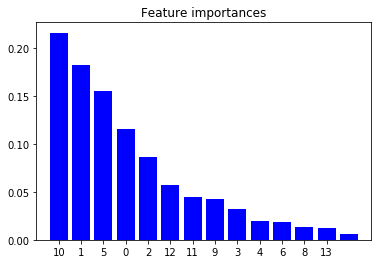

In [387]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), rf_importances[rf_indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), rf_indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [391]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [393]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [396]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [397]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("suzukiry_titanic_23-Nov-2017.csv", index=False)